In [ ]:
from nerfstudio.generative.diffusion_model import DiffusionModelConfig, DiffusionModelId, DiffusionModelType

In [19]:
from dataclasses import asdict

from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig
from nerfstudio.data.datamanagers.ad_datamanager import ADDataManagerConfig
from nerfstudio.data.dataparsers.pandaset_dataparser import PandaSetDataParserConfig
from nerfstudio.generative.diffusion_model import DiffusionModelConfig, DiffusionModelId, DiffusionModelType
from nerfstudio.models.neurad import NeuRADModel, NeuRADModelConfig
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfConfig

sequence = "001"

pipeline_config = DiffusionNerfConfig(
        max_steps=40001,
        calc_fid_steps=tuple(range(0, 40001, 5000)),
        ray_patch_size=(128, 128),
        nerf_checkpoint=f"models/diffusionnerf/base-neurad/{sequence}/nerfstudio_models/step-000040000.ckpt",
        datamanager=ADDataManagerConfig(
            dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front",), sequence=sequence),
            train_num_rays_per_batch=16384,
            eval_num_rays_per_batch=16384,
            num_processes=0
        ),
        model=NeuRADModelConfig(
            eval_num_rays_per_chunk=1 << 15,
            camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
            rgb_upsample_factor=4,
        ),
        diffusion_model=DiffusionModelConfig(
            type=DiffusionModelType.sd,
            id=DiffusionModelId.sd_v2_1,
            dtype="fp32",
            lora_weights=None,
            noise_strength=0.1,
            num_inference_steps=50,
            conditioning_scale=0.8,
            conditioning_signals=("ray",),
        ),
        augment_phase_step=0,
        max_aug_phase_step=20001,
        noise_start_phase_step=20001,
        noise_end_phase_step=40001,
        augment_strategy="partial_linear",
    )
pipeline = pipeline_config.setup(device="cuda")

Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


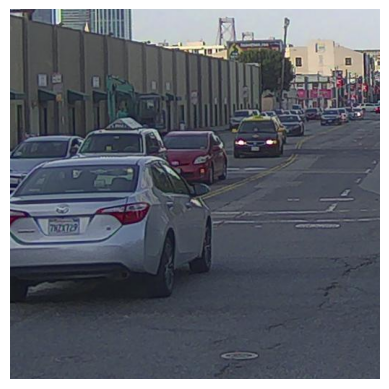

In [20]:
from nerfstudio.generative.utils import show_img


ray_bundle, batch = pipeline.datamanager.next_train(100)

img = batch["image"][0]
img.shape
show_img(img)


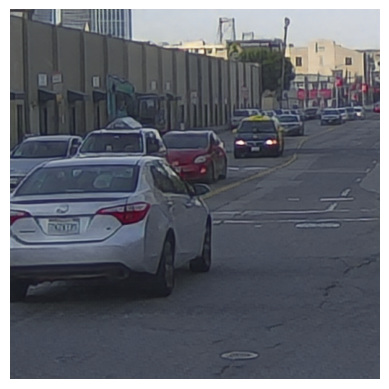

In [25]:
import torch
from copy import deepcopy

from nerfstudio.pipelines.diffusion_nerf_pipeline import PoseConfig, transform_ray_bundle

def shift_and_rotate(ray_bundle, pose_offset: PoseConfig):
    with torch.no_grad():
        aug_ray_bundle = transform_ray_bundle(ray_bundle, pose_offset.tensor_deg, pipeline.datamanager.train_dataset.cameras)
        aug_outputs = pipeline._model(deepcopy(aug_ray_bundle), patch_size=pipeline.config.ray_patch_size)
    return aug_ray_bundle, aug_outputs

aug_ray_bundle, aug_outputs = shift_and_rotate(ray_bundle, PoseConfig())

show_img(aug_outputs["rgb"][0])